In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Compose
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch.nn.functional as F
from tqdm.notebook import tqdm
import wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
train_transforms = Compose([
    ToTensor(),
    RandomHorizontalFlip(p=0.4),
])

test_transforms = Compose([
    ToTensor(),
])

In [4]:
dataset = ImageFolder('/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training', 
                            transform=train_transforms)

train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, shuffle=True)
train_dataset, val_dataset = Subset(dataset, train_indices), Subset(dataset, val_indices)
test_dataset = ImageFolder('/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test', 
                           transform=test_transforms)

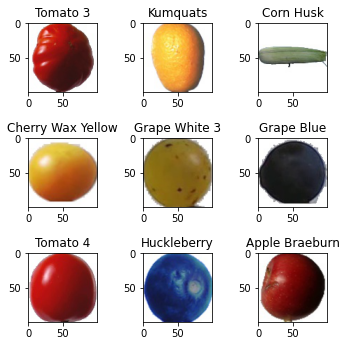

In [5]:
idx_to_class = {v: k for k, v in train_dataset.dataset.class_to_idx.items()}

width = 3
height = 3
fig, ax = plt.subplots(width,height, figsize=(5, 5))
fig.tight_layout(pad=1.5)
indices = np.random.randint(0, len(train_dataset), width * height)
idx = 0
for i in range(width):
    for j in range(height):
        image_info = train_dataset[indices[idx]]
        ax[i][j].imshow(image_info[0].permute((1,2,0)))
        ax[i][j].set_title(idx_to_class[image_info[1]])
        idx += 1

In [6]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'gpu'

In [7]:
class ConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, pool_padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU()
        
    def forward(self, x):
        return self.bn(self.leaky_relu(self.pool(self.conv(x))))

In [8]:
num_classes = len(train_dataset.dataset.classes)
num_classes

131

In [9]:
model_1 = nn.Sequential(
    ConvBlock2d(in_channels=3, out_channels=96, conv_kernel_size=3, conv_stride=2, conv_padding=0, pool_kernel_size=2, pool_stride=1, pool_padding=0),
    ConvBlock2d(in_channels=96, out_channels=256, conv_kernel_size=3, conv_stride=2, conv_padding=0, pool_kernel_size=4, pool_stride=2, pool_padding=0),
    nn.Flatten(),
    nn.Linear(25600, 10000),
    nn.BatchNorm1d(10000),
    nn.LeakyReLU(),
    nn.Linear(10000, 4096),
    nn.BatchNorm1d(4096),
    nn.LeakyReLU(),
    nn.Linear(4096, num_classes)
)


model_2 = resnet50(pretrained=True)
for param in model_2.parameters():
    param.requires_grad = False
model_2.fc = nn.Linear(2048, num_classes)

models = [("cnn", model_1), ("pretrained resnet50", model_2)]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    def _step(self, batch, name, on_step=True, on_epoch=True, prog_bar=True, logger=True):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log(name, loss, on_step=on_step, on_epoch=on_epoch, prog_bar=prog_bar, logger=logger)
        return loss
    
    def training_step(self, batch, batch_idx):
        self.train()
        return self._step(batch, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        self.eval()
        self._step(batch, "val_loss")
    
    def test_step(self, batch, batch_idx):
        self.eval()
        self._step(batch, "test_loss")
        
    def predict_step(self, batch, batch_idx):
        self.eval()
        x, _ = batch
        return self(x).argmax(dim=1)

In [11]:
for name, model in models:
    wandb_logger = WandbLogger(project="image-classification", name=name, save_dir="/kaggle/working/")
    trainer = pl.Trainer(accelerator=device, devices=1, max_epochs=1, logger=wandb_logger, log_every_n_steps=50, deterministic=True)
    model_light = CNNClassifier(model=model)
    wandb_logger.watch(model_light, log="all")
    trainer.fit(model_light)
    trainer.test(model_light)
    wandb_logger.experiment.finish()

wandb: Currently logged in as: olegggatttor. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.16318157315254211    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
test_loss_epoch,▁
test_loss_step,▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▃▁▁▁▄▁▁▁▁▁▁▁▁▁▂▁▁▂▁
train_loss_epoch,▁
train_loss_step,█▅▃▂▂▁▁▁▁▂▁▁▁▁▂▁
trainer/global_step,▄█▁▁▁▁▂▂▂▂▂▂▂▃▃▃▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄
val_loss_epoch,▁
val_loss_step,▁▂▄▂▇▄▃█▅▃▃▃▂▄▂▂▄▂▂▅▅▂▁▃▂▃▄▂▂▄▄▂▃▅▃▃▁▄▆▁
epoch,1
test_loss_epoch,0.16318
test_loss_step,0.00317


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.24262772500514984    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
test_loss_epoch,▁
test_loss_step,▂▃▅▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▄▁▂▅▂▁▁▁▃▁▂▁▁█▁
train_loss_epoch,▁
train_loss_step,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▄█▁▁▁▁▂▂▂▂▂▂▂▃▃▃▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄
val_loss_epoch,▁
val_loss_step,▃▄▄▅▄▂▄▂▄▅▃▃▄▅▄▂▆▃▃█▅▂▁▃▃▄▃▄▆▃▂▃▂▃▃▄▆▅▄▂
epoch,1
test_loss_epoch,0.24263
test_loss_step,0.15074


In [12]:
def print_f1(model, loader, targets):
    from sklearn.metrics import f1_score

    predicts = trainer.predict(model, loader)
    predicts = torch.concat(predicts).numpy()
    targets = targets
    print('Test F1-macro', f1_score(targets, predicts, average="macro"))

In [16]:
for name, model in models:
    print(f"Modeel: {name}")
    model_light = CNNClassifier(model=model)
    print_f1(model_light, model_light.test_dataloader(), test_dataset.targets)

Modeel: cnn


Predicting: 847it [00:00, ?it/s]

Test F1-macro 0.9480305785467656
Modeel: pretrained resnet50


Predicting: 847it [00:00, ?it/s]

Test F1-macro 0.9533900735744667
